In [4]:
# 폰트 추가로 그래프를 그렸을때 잘 나올 수 있도록 설정해주기

%matplotlib inline

import matplotlib as mpl  # 기본 설정
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # 폰트 관리


!apt-get update -qq         # apt-get 패키지 설치 명령어, -qq : 에러외 메세지 숨기기
!apt-get install fonts-nanum* -qq #나눔글꼴 설치

fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic') #파일 저장되어있는 경로와 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) #폰트설정

In [2]:
!pip install catboost
!pip install optuna

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

import datetime
import random
import os
import sys
import warnings

import sklearn
import catboost
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from itertools import combinations
import numpy as np

In [6]:
# 시드 고정
def seed_everything(seed: int = 2024):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(2024)

데이터 불러오기

In [7]:
# 일시는 datetime 형식으로 받아온다.
train = pd.read_csv("train.csv", parse_dates=["일시"])
submit = pd.read_csv("sample_submission.csv")

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일시      23011 non-null  datetime64[ns]
 1   최고기온    23008 non-null  float64       
 2   최저기온    23008 non-null  float64       
 3   일교차     23007 non-null  float64       
 4   강수량     9150 non-null   float64       
 5   평균습도    23011 non-null  float64       
 6   평균풍속    23007 non-null  float64       
 7   일조합     22893 non-null  float64       
 8   일사합     18149 non-null  float64       
 9   일조율     22645 non-null  float64       
 10  평균기온    23011 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.9 MB


**특성 조사**
- 최고기온 : 하루 동안의 가장 높은 기온
- 최저기온 : 하루 동안의 가장 낮은 기온
- 일교차 : 최고기온과 최저기온의 차이
- 강수량 : 비, 눈, 우박, 안개 등 땅에 내린 물의 총 양
- 습도 : 공기 중에 포함된 수분의 정도
- 풍속 : 단위시간당 이동하는 공기의 속도(바람의 속도)
 -일조합 : 지표면에 도달하는 햇빛의 총 시간(태양이 가려진 시간은 제외됨)
- 일조율 : 일조합이 기대되는 일조시간에 대한 비율
  ex 하루에 기대되는 일조시간이 10시간일때, 일조합이 5시간이라면, 일조율은 50%가 된다.
- 일사합 : 특정 지점의 표면에 도달한 태양광 에너지의 양

train과 submit의 날짜 범위 확인

In [9]:
train_min = min(train['일시'])
train_max = max(train['일시'])

sub_min = min(submit['일시'])
sub_max = max(submit['일시'])

display(f"train 데이터 기간 : {train_min} ~ {train_max}")
display(f"submit 데이터 기간 : {sub_min} ~ {sub_max}")

'train 데이터 기간 : 1960-01-01 00:00:00 ~ 2022-12-31 00:00:00'

'submit 데이터 기간 : 2023-01-01 ~ 2023-12-24'

train data에 날짜가 중복되었는지 확인

In [10]:
train[train['일시'].duplicated() == True]

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온


### 데이터전처리

In [11]:
train.isnull().sum()

일시          0
최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

결측치의 존재를 확인했다.

In [12]:
# '일시'를 인덱스로 설정하고 빈도를 'D'로 설정
train = train.set_index('일시')

In [13]:
# 최저기온, 최고기온, 일교차 결측치 확인
condition1 = train['최고기온'].isna()
condition2 = train['최저기온'].isna()
condition3 = train['일교차'].isna()

train[condition1 | condition2 | condition3]

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1967-02-19,NaN,NaN,NaN,NaN,62.0,1.8,9.5,NaN,93.1,-1.7
1973-10-16,NaN,NaN,NaN,0.4,74.0,1.8,3.5,9.24,29.7,12.3
2017-10-12,NaN,8.8,NaN,NaN,71.0,2.0,NaN,2.23,0.0,11.4
2022-08-08,28.4,NaN,NaN,129.6,91.6,3.3,NaN,NaN,0.0,26.8


- 일교차, 최고기온, 최저기온은 이중 2개만 값이 있어도 나머지 하나를 채울 수 있는 속성이다.
- 2개가 같이 있는 경우는 없었다.

In [14]:
# 최고기온과 최저기온의 결측값을 선형 보간법으로 채우기
train['최고기온'] = train['최고기온'].interpolate(method='linear')
train['최저기온'] = train['최저기온'].interpolate(method='linear')

# '일교차'가 결측인 경우에 한하여 최고기온과 최저기온의 차로 '일교차' 계산
train.loc[train['일교차'].isna(), '일교차'] = train['최고기온'] - train['최저기온']

# 결측값 대체 확인
display(train[condition1 | condition2 | condition3])
print(train.isnull().sum())

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
일시,,,,,,,,,,
1967-02-19,3.25,-6.15,9.40,NaN,62.0,1.8,9.5,NaN,93.1,-1.7
1973-10-16,17.00,5.65,11.35,0.4,74.0,1.8,3.5,9.24,29.7,12.3
2017-10-12,20.30,8.80,11.50,NaN,71.0,2.0,NaN,2.23,0.0,11.4
2022-08-08,28.40,24.60,3.80,129.6,91.6,3.3,NaN,NaN,0.0,26.8


최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64


- 최고기온과 최저기온의 결측값을 선형 보간법으로 채웠다.
- 기온같은경우 전날 혹은 다음날과 크게 달라지지 않기때문에 앞뒤값을 이용한 보간법을 선택했다.
- 최고,최저기온을 통해 일교차를 채워주었다.

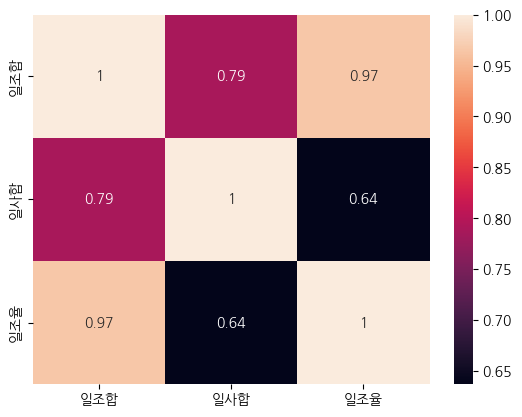

In [15]:
# 일조합과 일사합과 일조율이 높은 상관관계를 보임을 확인
import seaborn as sns
sun_data = train[['일조합', '일사합', '일조율']]

sns.heatmap(sun_data.corr(), annot = True)
plt.show()

- 일조합,일조율의 상관계수가 0.97
- 일조합,일사합의 상관계수가 0.79
- 일조율,일사합의 상관계수가 0.64

일조합, 일조율, 일사합은 서로 높은 상관관계를 가진다. 그렇기 때문에 서로를 이용해서 null값을 채워줄 것이다.

In [16]:
# 일조율 결측값을 채우기 위한 모델 정의
fill_rate_model = LinearRegression()

# 결측값이 없는 데이터로 모델을 학습
not_null_data = train[(train['일조합'].notna()) & (train['일조율'].notna())]

# 독립변수로 '일조합'을 사용
X = not_null_data[['일조합']]
y = not_null_data['일조율']
fill_rate_model.fit(X, y)

# 일조율 결측값을 예측하여 채우기
is_null_일조율 = train['일조율'].isna()
train.loc[is_null_일조율, '일조율'] = fill_rate_model.predict(train.loc[is_null_일조율, ['일조합']])



# 독립변수로 '일조율'을 사용
X = train[['일조율']]
y = train['일조합'].dropna()

# 일조합 결측값을 채우기 위한 모델 정의
fill_sum_model = LinearRegression()
fill_sum_model.fit(X[~train['일조합'].isna()], y)

# 일조합 결측값을 예측하여 채우기
is_null_일조합 = train['일조합'].isna()
train.loc[is_null_일조합, '일조합'] = fill_sum_model.predict(train.loc[is_null_일조합, ['일조율']])

# 모든 결측값이 채워졌는지 확인
train.isnull().sum()

최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        4
일조합         0
일사합      4862
일조율         0
평균기온        0
dtype: int64

- 일조합의 null : 118개
- 일조율의 null : 366개

null의 개수가 더 작은 일조합을 먼저 학습시켜서 일조율을 예측하고,
다 채워진 일조율을 통해 일조합을 예측했다.

In [17]:
# 일사합 결측값을 채우기 위한 모델 정의
fill_irradiance_model = LinearRegression()

# 결측값이 없는 데이터로 모델을 학습
not_null_irradiance_data = train[(train['일조합'].notna()) & (train['일사합'].notna())]

# 독립변수로 '일조합'을 사용
X_irradiance = not_null_irradiance_data[['일조합']]
y_irradiance = not_null_irradiance_data['일사합']
fill_irradiance_model.fit(X_irradiance, y_irradiance)

# 일사합 결측값을 예측하여 채우기
is_null_일사합 = train['일사합'].isna()
train.loc[is_null_일사합, '일사합'] = fill_irradiance_model.predict(train.loc[is_null_일사합, ['일조합']])

# 모든 결측값이 채워졌는지 확인
train.isnull().sum()

최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        4
일조합         0
일사합         0
일조율         0
평균기온        0
dtype: int64

일사합을 채울때는 더 높은 상관계수(0.79)를 보여줬던 일조합을 이용해서 값을 예측해줬다.

In [18]:
# 일자에서 월 추출
train['월'] = train.index.month

# 각 월별 평균풍속의 중앙값 계산
median_wind_speed_per_month = train.groupby('월')['평균풍속'].median()

# 각 월별로 평균풍속 결측값을 해당 월의 중앙값으로 대체
for month, median in median_wind_speed_per_month.items():
    train.loc[(train['월'] == month) & (train['평균풍속'].isna()), '평균풍속'] = median

# 더 이상 필요하지 않은 '월' 컬럼 삭제
train.drop('월', axis=1, inplace=True)

# 결측값이 잘 대체되었는지 확인
train.isnull().sum()

최고기온        0
최저기온        0
일교차         0
강수량     13861
평균습도        0
평균풍속        0
일조합         0
일사합         0
일조율         0
평균기온        0
dtype: int64

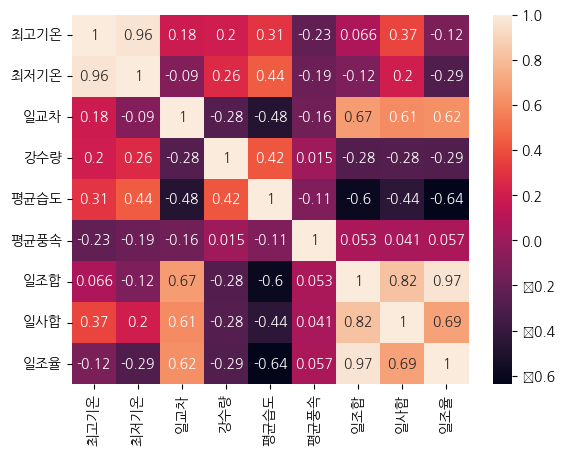

In [19]:
columns = train[['최고기온','최저기온','일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율']]

sns.heatmap(columns.corr(), annot = True)
plt.show()

In [20]:
train['강수량'].fillna(method='bfill', inplace = True)
train.isnull().sum()

최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

- 강수량의 경우 다른 강한 상관관계를 가진 속성이 있지않다.
- 강수량도 기온과 같이 대체로 비슷한 같은 가져갈 수 있다고 생각해서, 바로 전값으로 결측치를 채워주었다.

In [ ]:
# from scipy import stats

# # 일시를 제외한 다른 특성들을 선택
# features_org = train.columns[1:]
# train_x = train[features_org]

# # Z-score 기반 이상치 재탐지
# def detect_z_scores_outliers(dataframe, column):
#     z_scores = np.abs(stats.zscore(dataframe))
#     threshold = 3

#     return z_scores[z_scores[column] >= threshold].index

# z_scores_outliers_dict = {}
# for column in features_org:
#     outliers = detect_z_scores_outliers(train_x, column)
#     if len(outliers) > 0:
#         z_scores_outliers_dict[column] = outliers
#     display(f"num of outlier of {column} : {len(outliers)}")

In [21]:
# 전처리된 데이터 저장
train.to_csv('preprocessing_train.csv', index = True)

In [22]:
train = train.reset_index()

### 파생변수 생성

In [23]:
submit["일시"] = pd.to_datetime(submit["일시"])

In [24]:
#년/월/일 추가

train['년']=train['일시'].dt.year
train['월']=train['일시'].dt.month
train['일']=train['일시'].dt.day

submit['년']=submit['일시'].dt.year
submit['월']=submit['일시'].dt.month
submit['일']=submit['일시'].dt.day

In [25]:
# 날짜 데이터
date_data = pd.date_range(start='1960-01-01', end='2022-12-31', freq='D')

# 일 단위 추출
day_of_year = date_data.dayofyear

# 주기 함수로 변환
train['Day sin'] = np.sin(2 * np.pi * day_of_year / 365)
train['Day cos'] = np.cos(2 * np.pi * day_of_year / 365)

주기성을 파악하기 위해서, sin, cos 주기함수 새성

In [26]:
# 날짜 데이터
date_data2 = pd.date_range(start='2023-01-01', end='2023-12-24', freq='D')

# 일 단위 추출
day_of_year2 = date_data2.dayofyear

# 주기 함수로 변환
submit['Day sin'] = np.sin(2 * np.pi * day_of_year2 / 358)
submit['Day cos'] = np.cos(2 * np.pi * day_of_year2 / 358)

In [27]:
# 주차 변수 추가
train["주"] = train["일시"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])
submit["주"] = submit["일시"].map(lambda x: datetime.datetime(x.year, x.month, x.day).isocalendar()[1])

### 강수량속성 전처리

In [28]:
train["강수량"].describe()

count    23011.000000
mean         7.395932
std         17.261952
min          0.000000
25%          0.000000
50%          1.000000
75%          6.500000
max        332.800000
Name: 강수량, dtype: float64

In [29]:
train[train["강수량"] == 0]["강수량"].count()

6608

- 총 23011개중에 강수량이 0인날이 6608일로 꽤 많은 비중을 차지하는것을 확인했다.
- 또한 강수량이 가장 이상치(일정 값 이상)가 많은 항목이므로 고민해본다.

In [30]:
sun = train[train["강수량"] == 0].copy()
rain = train[train["강수량"] != 0].copy()

In [31]:
sun.describe()

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월,일,Day sin,Day cos,주
count,6608.000000,6608.000000,6608.000000,6608.0,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000,6608.000000
mean,15.229479,6.189225,9.040254,0.0,61.202043,2.378844,6.692330,12.861050,56.639119,10.349364,1989.623638,6.303874,15.655569,0.038338,0.117768,25.519370
std,11.610730,11.043733,2.577783,0.0,12.685183,0.923730,3.374709,5.623198,27.970843,11.205195,18.254847,3.699836,8.810966,0.688159,0.715015,16.181025
min,-13.600000,-19.200000,1.200000,0.0,20.800000,0.100000,0.000000,0.210000,0.000000,-16.400000,1960.000000,1.000000,1.000000,-0.999991,-0.999963,1.000000
25%,5.100000,-3.000000,7.200000,0.0,52.300000,1.700000,4.300000,8.530000,36.200000,0.800000,1974.000000,3.000000,8.000000,-0.642055,-0.618671,10.000000
50%,15.800000,5.800000,8.900000,0.0,61.800000,2.200000,7.450000,12.510152,64.000000,10.400000,1988.000000,6.000000,16.000000,0.103102,0.259512,24.000000
75%,25.900000,16.000000,10.800000,0.0,70.500000,2.800000,9.200000,16.730000,80.700000,20.525000,2005.000000,10.000000,23.000000,0.693281,0.833556,41.000000
max,38.400000,28.700000,18.500000,0.0,92.500000,7.400000,13.700000,31.110000,95.900000,33.100000,2022.000000,12.000000,31.000000,0.999991,1.000000,53.000000


In [32]:
rain.describe()

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월,일,Day sin,Day cos,주
count,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000,16403.000000
mean,17.813214,9.363434,8.449781,10.375407,66.814589,2.381772,5.481915,11.496241,45.414089,13.247735,1991.553496,6.611108,15.759678,-0.015428,-0.046468,27.022740
std,10.238213,10.245407,3.013226,19.675042,14.936189,0.956971,3.944546,6.320619,32.457977,10.068257,18.127635,3.338394,8.796153,0.713717,0.698764,14.566542
min,-10.700000,-20.200000,1.000000,0.100000,17.900000,0.100000,0.000000,0.000000,0.000000,-14.900000,1960.000000,1.000000,1.000000,-0.999991,-0.999963,1.000000
25%,9.200000,0.900000,6.300000,0.700000,56.100000,1.700000,1.300000,6.170000,10.500000,4.900000,1976.000000,4.000000,8.000000,-0.729558,-0.732494,15.000000
50%,19.700000,10.300000,8.500000,3.100000,67.500000,2.200000,6.100000,11.055974,50.813230,14.700000,1992.000000,7.000000,16.000000,-0.051620,-0.098820,27.000000
75%,26.500000,18.500000,10.500000,10.600000,78.300000,2.900000,8.900000,16.220000,76.200000,22.100000,2007.000000,9.000000,23.000000,0.711657,0.651899,39.000000
max,39.600000,30.300000,19.600000,332.800000,99.800000,7.800000,13.600000,33.480000,100.299895,33.700000,2022.000000,12.000000,31.000000,0.999991,1.000000,53.000000


강수량을 값에 따라 범위를 나눈다.
- 0 : not_rain(0)
- 0초과 0.7이하 : rain_level_1(1)
- 0.7초과 3.1이하: rain_level_2(2)
- 3.1초과 10.6이하 : rain_level_3(3)
-10.6초과 max()이하 : rain_level_4(4)


In [33]:
# 강수량을 범주화하는 함수
def categorize_precipitation(precipitation):
    if precipitation <= 0:
        return 0
    elif 0 < precipitation <= 0.7:
        return 1
    elif 0.7 < precipitation <= 3.1:
        return 2
    elif 3.1 < precipitation <= 10.6:
        return 3
    else:
        return 4

# 강수량을 범주화하여 새로운 열에 저장
train["강수량"] = train["강수량"].apply(categorize_precipitation)

In [34]:
train.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,년,월,일,Day sin,Day cos,주
0,1960-01-01,2.2,-5.2,7.4,1,68.3,1.7,6.7,13.038944,55.602262,-1.6,1960,1,1,0.017213,0.999852,53
1,1960-01-02,1.2,-5.6,6.8,1,87.7,1.3,0.0,4.181680,2.124736,-1.9,1960,1,2,0.034422,0.999407,53
2,1960-01-03,8.7,-2.1,10.8,0,81.3,3.0,0.0,4.181680,2.124736,4.0,1960,1,3,0.051620,0.998667,53
3,1960-01-04,10.8,1.2,9.6,0,79.7,4.4,2.6,7.618827,22.877209,7.5,1960,1,4,0.068802,0.997630,1
4,1960-01-05,1.3,-8.2,9.5,0,44.0,5.1,8.2,15.021913,67.574842,-4.6,1960,1,5,0.085965,0.996298,1


### 속성예측(독립변수 예측 순서)

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
    combinations_list.append(list(combination))

combinations_list

[['년'],
 ['월'],
 ['Day sin'],
 ['Day cos'],
 ['년', '월'],
 ['년', 'Day sin'],
 ['년', 'Day cos'],
 ['월', 'Day sin'],
 ['월', 'Day cos'],
 ['Day sin', 'Day cos'],
 ['년', '월', 'Day sin'],
 ['년', '월', 'Day cos'],
 ['년', 'Day sin', 'Day cos'],
 ['월', 'Day sin', 'Day cos'],
 ['년', '월', 'Day sin', 'Day cos']]

In [ ]:
target_variables = ['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율']

for target in target_variables:
    for combination in combinations_list:
      selected_features = combination
      one_target= target

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[one_target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)


      # K-Fold 교차 검증 결과 출력
      print(f"선택된 속성 : {selected_features}, 타겟 : {one_target}, MAE: {np.mean(mae_scores)}")

선택된 속성 : ['년'], 타겟 : 최고기온, MAE: 9.325493643117339
선택된 속성 : ['월'], 타겟 : 최고기온, MAE: 3.203578282923334
선택된 속성 : ['Day sin'], 타겟 : 최고기온, MAE: 7.108976320673719
선택된 속성 : ['Day cos'], 타겟 : 최고기온, MAE: 4.095114779087986
선택된 속성 : ['년', '월'], 타겟 : 최고기온, MAE: 3.087918270651129
선택된 속성 : ['년', 'Day sin'], 타겟 : 최고기온, MAE: 7.348885611250499
선택된 속성 : ['년', 'Day cos'], 타겟 : 최고기온, MAE: 4.034684694912253
선택된 속성 : ['월', 'Day sin'], 타겟 : 최고기온, MAE: 2.9478616761144494
선택된 속성 : ['월', 'Day cos'], 타겟 : 최고기온, MAE: 2.94547270824515
선택된 속성 : ['Day sin', 'Day cos'], 타겟 : 최고기온, MAE: 2.9477554224731977
선택된 속성 : ['년', '월', 'Day sin'], 타겟 : 최고기온, MAE: 2.791881135412541
선택된 속성 : ['년', '월', 'Day cos'], 타겟 : 최고기온, MAE: 2.7864280147809204
선택된 속성 : ['년', 'Day sin', 'Day cos'], 타겟 : 최고기온, MAE: 2.785365528314253
선택된 속성 : ['월', 'Day sin', 'Day cos'], 타겟 : 최고기온, MAE: 2.9474085427415733
선택된 속성 : ['년', '월', 'Day sin', 'Day cos'], 타겟 : 최고기온, MAE: 2.7868062886215035
선택된 속성 : ['년'], 타겟 : 최저기온, MAE: 9.148526024994954
선택된 속성 : ['월'],

처음 예측할 속성은 가장 MAE가 낮았던 평균풍속이다.
- 사용속성 : ['년', '월', 'Day sin', 'Day cos'], 타겟 : 평균풍속, MAE: 0.663

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos', '평균풍속']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
    combinations_list.append(list(combination))

combinations_list

[['년'],
 ['월'],
 ['Day sin'],
 ['Day cos'],
 ['평균풍속'],
 ['년', '월'],
 ['년', 'Day sin'],
 ['년', 'Day cos'],
 ['년', '평균풍속'],
 ['월', 'Day sin'],
 ['월', 'Day cos'],
 ['월', '평균풍속'],
 ['Day sin', 'Day cos'],
 ['Day sin', '평균풍속'],
 ['Day cos', '평균풍속'],
 ['년', '월', 'Day sin'],
 ['년', '월', 'Day cos'],
 ['년', '월', '평균풍속'],
 ['년', 'Day sin', 'Day cos'],
 ['년', 'Day sin', '평균풍속'],
 ['년', 'Day cos', '평균풍속'],
 ['월', 'Day sin', 'Day cos'],
 ['월', 'Day sin', '평균풍속'],
 ['월', 'Day cos', '평균풍속'],
 ['Day sin', 'Day cos', '평균풍속'],
 ['년', '월', 'Day sin', 'Day cos'],
 ['년', '월', 'Day sin', '평균풍속'],
 ['년', '월', 'Day cos', '평균풍속'],
 ['년', 'Day sin', 'Day cos', '평균풍속'],
 ['월', 'Day sin', 'Day cos', '평균풍속'],
 ['년', '월', 'Day sin', 'Day cos', '평균풍속']]

In [ ]:
target_variables = ['최고기온', '최저기온', '일교차', '강수량', '평균습도', '일조합', '일사합', '일조율']

for target in target_variables:
    for combination in combinations_list:
      selected_features = combination
      one_target= target

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[one_target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)


      # K-Fold 교차 검증 결과 출력
      print(f"선택된 속성 : {selected_features}, 타겟 : {one_target}, MAE: {np.mean(mae_scores)}")
    print("\n")

선택된 속성 : ['년'], 타겟 : 최고기온, MAE: 9.325493643117339
선택된 속성 : ['월'], 타겟 : 최고기온, MAE: 3.203578282923334
선택된 속성 : ['Day sin'], 타겟 : 최고기온, MAE: 7.108976320673719
선택된 속성 : ['Day cos'], 타겟 : 최고기온, MAE: 4.095114779087986
선택된 속성 : ['평균풍속'], 타겟 : 최고기온, MAE: 8.99042143104651
선택된 속성 : ['년', '월'], 타겟 : 최고기온, MAE: 3.087918270651129
선택된 속성 : ['년', 'Day sin'], 타겟 : 최고기온, MAE: 7.348885611250499
선택된 속성 : ['년', 'Day cos'], 타겟 : 최고기온, MAE: 4.034684694912253
선택된 속성 : ['년', '평균풍속'], 타겟 : 최고기온, MAE: 8.93934356061318
선택된 속성 : ['월', 'Day sin'], 타겟 : 최고기온, MAE: 2.9478616761144494
선택된 속성 : ['월', 'Day cos'], 타겟 : 최고기온, MAE: 2.94547270824515
선택된 속성 : ['월', '평균풍속'], 타겟 : 최고기온, MAE: 3.0264592705985955
선택된 속성 : ['Day sin', 'Day cos'], 타겟 : 최고기온, MAE: 2.9477554224731977
선택된 속성 : ['Day sin', '평균풍속'], 타겟 : 최고기온, MAE: 7.1706199568720805
선택된 속성 : ['Day cos', '평균풍속'], 타겟 : 최고기온, MAE: 3.575884027739211
선택된 속성 : ['년', '월', 'Day sin'], 타겟 : 최고기온, MAE: 2.791881135412541
선택된 속성 : ['년', '월', 'Day cos'], 타겟 : 최고기온, MAE: 2.78642801

두번째로는 일교차를 예측한다.
- ['년', 'Day sin', 'Day cos', '평균풍속'], 타겟 : 일교차, MAE: 1.986

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
    combinations_list.append(list(combination))

combinations_list

In [ ]:
target_variables = ['최고기온', '최저기온', '강수량', '평균습도', '일조합', '일사합', '일조율']

for target in target_variables:
    for combination in combinations_list:
      selected_features = combination
      one_target= target

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[one_target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)


      # K-Fold 교차 검증 결과 출력
      print(f"선택된 속성 : {selected_features}, 타겟 : {one_target}, MAE: {np.mean(mae_scores)}")
    print("\n")

선택된 속성 : ['년'], 타겟 : 최고기온, MAE: 9.325493643117339
선택된 속성 : ['월'], 타겟 : 최고기온, MAE: 3.203578282923334
선택된 속성 : ['Day sin'], 타겟 : 최고기온, MAE: 7.108976320673719
선택된 속성 : ['Day cos'], 타겟 : 최고기온, MAE: 4.095114779087986
선택된 속성 : ['평균풍속'], 타겟 : 최고기온, MAE: 8.99042143104651
선택된 속성 : ['일교차'], 타겟 : 최고기온, MAE: 8.976596239566437
선택된 속성 : ['년', '월'], 타겟 : 최고기온, MAE: 3.087918270651129
선택된 속성 : ['년', 'Day sin'], 타겟 : 최고기온, MAE: 7.348885611250499
선택된 속성 : ['년', 'Day cos'], 타겟 : 최고기온, MAE: 4.034684694912253
선택된 속성 : ['년', '평균풍속'], 타겟 : 최고기온, MAE: 8.93934356061318
선택된 속성 : ['년', '일교차'], 타겟 : 최고기온, MAE: 8.955320086238657
선택된 속성 : ['월', 'Day sin'], 타겟 : 최고기온, MAE: 2.9478616761144494
선택된 속성 : ['월', 'Day cos'], 타겟 : 최고기온, MAE: 2.94547270824515
선택된 속성 : ['월', '평균풍속'], 타겟 : 최고기온, MAE: 3.0264592705985955
선택된 속성 : ['월', '일교차'], 타겟 : 최고기온, MAE: 2.7149170094205854
선택된 속성 : ['Day sin', 'Day cos'], 타겟 : 최고기온, MAE: 2.9477554224731977
선택된 속성 : ['Day sin', '평균풍속'], 타겟 : 최고기온, MAE: 7.1706199568720805
선택된 속성 : ['Day sin', 

세번째는 일조합을 예측한다.
- ['년', 'Day sin', 'Day cos', '평균풍속', '일교차'], 타겟 : 일조합, MAE: 1.793

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조합']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
    combinations_list.append(list(combination))

combinations_list

In [ ]:
target_variables = ['최고기온', '최저기온', '강수량', '평균습도', '일사합', '일조율']

for target in target_variables:
    for combination in combinations_list:
      selected_features = combination
      one_target= target

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[one_target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)


      # K-Fold 교차 검증 결과 출력
      print(f"선택된 속성 : {selected_features}, 타겟 : {one_target}, MAE: {np.mean(mae_scores)}")
    print("\n")

선택된 속성 : ['년'], 타겟 : 최고기온, MAE: 9.325493643117339
선택된 속성 : ['월'], 타겟 : 최고기온, MAE: 3.203578282923334
선택된 속성 : ['Day sin'], 타겟 : 최고기온, MAE: 7.108976320673719
선택된 속성 : ['Day cos'], 타겟 : 최고기온, MAE: 4.095114779087986
선택된 속성 : ['평균풍속'], 타겟 : 최고기온, MAE: 8.99042143104651
선택된 속성 : ['일교차'], 타겟 : 최고기온, MAE: 8.976596239566437
선택된 속성 : ['일조합'], 타겟 : 최고기온, MAE: 8.793572958756593
선택된 속성 : ['년', '월'], 타겟 : 최고기온, MAE: 3.087918270651129
선택된 속성 : ['년', 'Day sin'], 타겟 : 최고기온, MAE: 7.348885611250499
선택된 속성 : ['년', 'Day cos'], 타겟 : 최고기온, MAE: 4.034684694912253
선택된 속성 : ['년', '평균풍속'], 타겟 : 최고기온, MAE: 8.93934356061318
선택된 속성 : ['년', '일교차'], 타겟 : 최고기온, MAE: 8.955320086238657
선택된 속성 : ['년', '일조합'], 타겟 : 최고기온, MAE: 8.66604417957586
선택된 속성 : ['월', 'Day sin'], 타겟 : 최고기온, MAE: 2.9478616761144494
선택된 속성 : ['월', 'Day cos'], 타겟 : 최고기온, MAE: 2.94547270824515
선택된 속성 : ['월', '평균풍속'], 타겟 : 최고기온, MAE: 3.0264592705985955
선택된 속성 : ['월', '일교차'], 타겟 : 최고기온, MAE: 2.7149170094205854
선택된 속성 : ['월', '일조합'], 타겟 : 최고기온, MAE: 2.86467

네번째는 일조율을 예측한다.
- ['년', 'Day sin', 'Day cos', '일조합'], 타겟 : 일조율, MAE: 0.271

일조율과 일조합이 있으면 다음은 무조건 일사합을 예측하는게 당연할것이다.
그러므로 다음번에는 일사합의 조합만 확인하자.

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조합', '일조율']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
    combinations_list.append(list(combination))

combinations_list

In [ ]:
best_mae_dict = {}  # 각 타겟 변수별로 최적의 MAE와 조합을 저장할 딕셔너리 초기화
target_variables = ['일사합']

for target in target_variables:
    min_mae = float('inf')  # MAE의 초기 최솟값을 무한대로 설정
    best_combination = None  # 최적의 조합을 저장할 변수 초기화

    for combination in combinations_list:
      selected_features = combination
      one_target= target

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[one_target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)

      # 해당 타겟 변수에 대한 MAE가 이전 최솟값보다 작은 경우 갱신
      if np.mean(mae_scores) < min_mae:
        min_mae = np.mean(mae_scores)
        best_combination = selected_features

      # 최적의 MAE와 해당 조합을 딕셔너리에 저장
      best_mae_dict[target] = {'MAE': min_mae, 'Best Combination': best_combination}

# 결과 출력
for target, info in best_mae_dict.items():
    print(f"타겟 : {target}, 최적 MAE: {info['MAE']}, 최적 조합: {info['Best Combination']}")

타겟 : 일사합, 최적 MAE: 0.8784970160823411, 최적 조합: ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조합', '일조율']


일사합 예측
- ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조합', '일조율'],
 MAE : 0.878

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조합', '일조율', '일사합']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
  if len(combination) >= 5:
    combinations_list.append(list(combination))

combinations_list

In [ ]:
target_variables = ['최고기온', '최저기온', '평균습도', '강수량']

for target in target_variables:
    for combination in combinations_list:
      selected_features = combination

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)


      # K-Fold 교차 검증 결과 출력
      print(f"선택된 속성 : {selected_features}, 타겟 : {target}, MAE: {np.mean(mae_scores)}")
    print("\n")

선택된 속성 : ['년', '월', 'Day sin', 'Day cos', '평균풍속'], 타겟 : 최고기온, MAE: 2.634377190802467
선택된 속성 : ['년', '월', 'Day sin', 'Day cos', '일교차'], 타겟 : 최고기온, MAE: 2.240466597140327
선택된 속성 : ['년', '월', 'Day sin', 'Day cos', '일조합'], 타겟 : 최고기온, MAE: 2.3802940777893484
선택된 속성 : ['년', '월', 'Day sin', 'Day cos', '일조율'], 타겟 : 최고기온, MAE: 2.3718637786982915
선택된 속성 : ['년', '월', 'Day sin', 'Day cos', '일사합'], 타겟 : 최고기온, MAE: 2.3541999731109717
선택된 속성 : ['년', '월', 'Day sin', '평균풍속', '일교차'], 타겟 : 최고기온, MAE: 2.1718360508113594
선택된 속성 : ['년', '월', 'Day sin', '평균풍속', '일조합'], 타겟 : 최고기온, MAE: 2.2313244452467567
선택된 속성 : ['년', '월', 'Day sin', '평균풍속', '일조율'], 타겟 : 최고기온, MAE: 2.2282428520378454
선택된 속성 : ['년', '월', 'Day sin', '평균풍속', '일사합'], 타겟 : 최고기온, MAE: 2.2354982835205406
선택된 속성 : ['년', '월', 'Day sin', '일교차', '일조합'], 타겟 : 최고기온, MAE: 2.0798978011948184
선택된 속성 : ['년', '월', 'Day sin', '일교차', '일조율'], 타겟 : 최고기온, MAE: 2.0805692068632182
선택된 속성 : ['년', '월', 'Day sin', '일교차', '일사합'], 타겟 : 최고기온, MAE: 2.082114923112324
선택된 속성

KeyboardInterrupt: 

최저기온 먼저 예측
- ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조율', '일사합'], 타겟 : 최저기온, MAE: 2.009

최고기온 예측
- 최고기온 : 최저기온 + 일교차

평균습도 예측

강수량 예측

In [ ]:
# 주어진 변수
variables = ['년', '월', 'Day sin', 'Day cos', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최고기온', '최저기온', '평균습도', '강수량']

# 가능한 모든 조합을 저장할 리스트 초기화
all_combinations = []
combinations_list = []

# 변수의 개수에 따라 가능한 모든 조합 생성
for r in range(1, len(variables) + 1):
    combinations_r = combinations(variables, r)
    all_combinations.extend(combinations_r)

# 결과(튜플형식)를 리스트형식으로 바꿔서 combinations_list에 저장
for combination in all_combinations:
    combinations_list.append(list(combination))

combinations_list

[['년'],
 ['월'],
 ['Day sin'],
 ['Day cos'],
 ['평균풍속'],
 ['일교차'],
 ['일조합'],
 ['일조율'],
 ['일사합'],
 ['최고기온'],
 ['최저기온'],
 ['평균습도'],
 ['강수량'],
 ['년', '월'],
 ['년', 'Day sin'],
 ['년', 'Day cos'],
 ['년', '평균풍속'],
 ['년', '일교차'],
 ['년', '일조합'],
 ['년', '일조율'],
 ['년', '일사합'],
 ['년', '최고기온'],
 ['년', '최저기온'],
 ['년', '평균습도'],
 ['년', '강수량'],
 ['월', 'Day sin'],
 ['월', 'Day cos'],
 ['월', '평균풍속'],
 ['월', '일교차'],
 ['월', '일조합'],
 ['월', '일조율'],
 ['월', '일사합'],
 ['월', '최고기온'],
 ['월', '최저기온'],
 ['월', '평균습도'],
 ['월', '강수량'],
 ['Day sin', 'Day cos'],
 ['Day sin', '평균풍속'],
 ['Day sin', '일교차'],
 ['Day sin', '일조합'],
 ['Day sin', '일조율'],
 ['Day sin', '일사합'],
 ['Day sin', '최고기온'],
 ['Day sin', '최저기온'],
 ['Day sin', '평균습도'],
 ['Day sin', '강수량'],
 ['Day cos', '평균풍속'],
 ['Day cos', '일교차'],
 ['Day cos', '일조합'],
 ['Day cos', '일조율'],
 ['Day cos', '일사합'],
 ['Day cos', '최고기온'],
 ['Day cos', '최저기온'],
 ['Day cos', '평균습도'],
 ['Day cos', '강수량'],
 ['평균풍속', '일교차'],
 ['평균풍속', '일조합'],
 ['평균풍속', '일조율'],
 ['평균풍속', '일사합'],
 ['평균풍속', '최

In [ ]:
target_variables = ['평균기온']

for target in target_variables:
    for combination in combinations_list:
      selected_features = combination

      # 선택된 변수들을 사용하여 훈련 데이터셋 준비
      train_x = train[selected_features]
      train_y = train[target]

      # K-Fold 교차 검증을 위한 K 값 설정
      k = 5
      kf = KFold(n_splits=k, shuffle=True, random_state=42)

      # 모델 정의
      cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

      # MAE를 저장할 리스트 초기화
      mae_scores = []

      # K-Fold 교차 검증 수행
      for train_index, val_index in kf.split(train_x):
          # 훈련 세트, 검증 세트 분할
          X_train_kf, X_val_kf = train_x.iloc[train_index], train_x.iloc[val_index]
          y_train_kf, y_val_kf = train_y.iloc[train_index], train_y.iloc[val_index]

          # 모델 학습
          cat.fit(X_train_kf, y_train_kf)

          # 검증 세트에 대한 예측
          val_preds_kf = cat.predict(X_val_kf)

          # MAE 계산 및 리스트에 추가
          val_mae_kf = mean_absolute_error(y_val_kf, val_preds_kf)
          mae_scores.append(val_mae_kf)


      # K-Fold 교차 검증 결과 출력
      print(f"선택된 속성 : {selected_features}, 타겟 : {target}, MAE: {np.mean(mae_scores)}")
    print("\n")

선택된 속성 : ['년'], 타겟 : 평균기온, MAE: 9.122017342656497
선택된 속성 : ['월'], 타겟 : 평균기온, MAE: 2.801886874199738
선택된 속성 : ['Day sin'], 타겟 : 평균기온, MAE: 6.825747359235018
선택된 속성 : ['Day cos'], 타겟 : 평균기온, MAE: 4.0016446861783965
선택된 속성 : ['평균풍속'], 타겟 : 평균기온, MAE: 8.833153390854894
선택된 속성 : ['일교차'], 타겟 : 평균기온, MAE: 8.913920662747941
선택된 속성 : ['일조합'], 타겟 : 평균기온, MAE: 8.618850520714087
선택된 속성 : ['일조율'], 타겟 : 평균기온, MAE: 8.745552437270138
선택된 속성 : ['일사합'], 타겟 : 평균기온, MAE: 8.321912568832293
선택된 속성 : ['최고기온'], 타겟 : 평균기온, MAE: 1.1940236808078584
선택된 속성 : ['최저기온'], 타겟 : 평균기온, MAE: 1.1766315575083113
선택된 속성 : ['평균습도'], 타겟 : 평균기온, MAE: 8.314336277820335
선택된 속성 : ['강수량'], 타겟 : 평균기온, MAE: 8.470911189747783
선택된 속성 : ['년', '월'], 타겟 : 평균기온, MAE: 2.68710828499022
선택된 속성 : ['년', 'Day sin'], 타겟 : 평균기온, MAE: 7.195881335791893
선택된 속성 : ['년', 'Day cos'], 타겟 : 평균기온, MAE: 3.94856256466824
선택된 속성 : ['년', '평균풍속'], 타겟 : 평균기온, MAE: 8.784826182000103
선택된 속성 : ['년', '일교차'], 타겟 : 평균기온, MAE: 8.890888477889005
선택된 속성 : ['년', '일조합'], 

### 속성예측(RFECV)

평균기온

In [32]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train.drop(["일시", "평균기온"], axis=1)
train_y = train["평균기온"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=10, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=10,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c759df3d330>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

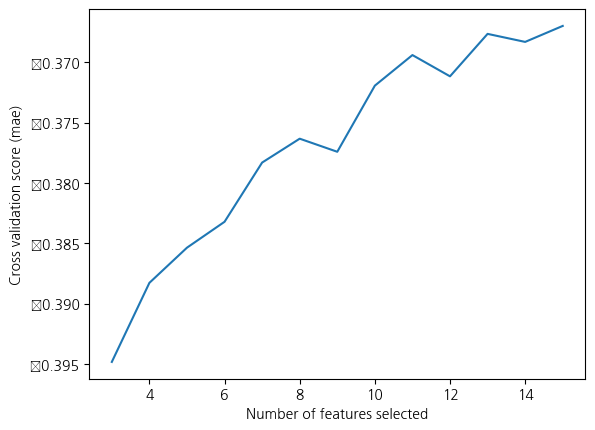

In [33]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [35]:
selector.support_.sum()

15

In [36]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율', '년',
       '월', '일', 'Day sin', 'Day cos', '주'],
      dtype='object')

많은 행을 쓰면 쓸수록 결과가 좋게 나옴을 인지했다.

평균풍속 예측

In [39]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주']]
train_y = train["평균풍속"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=10, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=10,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c759ddcff40>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

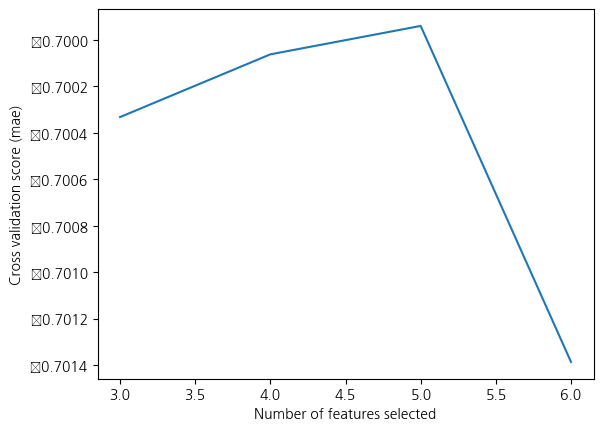

In [40]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [41]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['년', '월', 'Day sin', 'Day cos', '주'], dtype='object')

일교차 예측

In [42]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속']]
train_y = train["일교차"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=10, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=10,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c757153a140>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

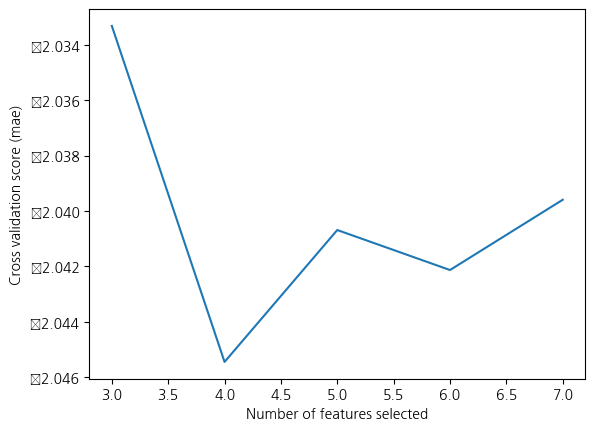

In [43]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [44]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['Day sin', 'Day cos', '평균풍속'], dtype='object')

일조합 예측

In [45]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차']]
train_y = train["일조합"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c7597eb7670>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

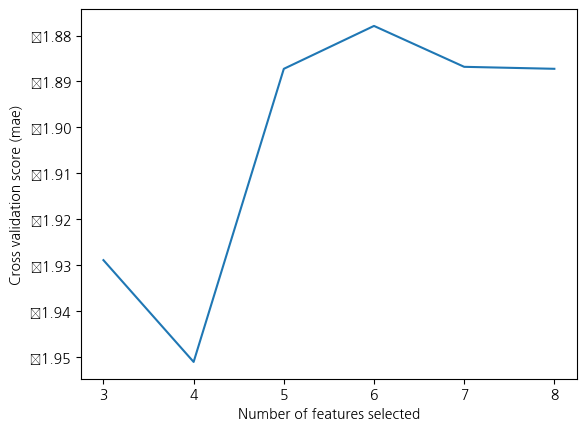

In [46]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [47]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['년', 'Day sin', 'Day cos', '주', '평균풍속', '일교차'], dtype='object')

일조율 예측

In [48]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합']]
train_y = train["일조율"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c75712c22f0>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

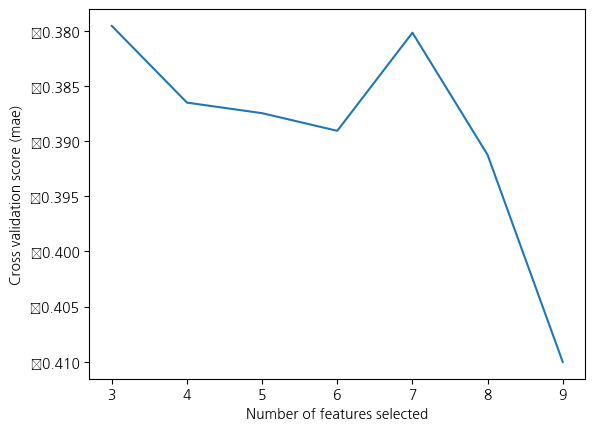

In [49]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [50]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['Day cos', '주', '일조합'], dtype='object')

일사합 예측

In [51]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율']]
train_y = train["일사합"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c75715b2da0>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

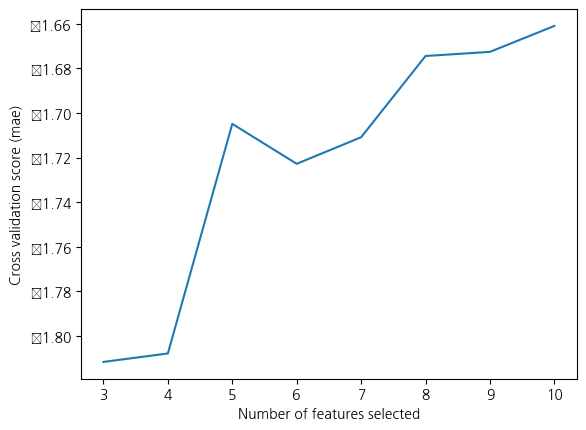

In [52]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [53]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율'], dtype='object')

최저기온 예측

In [54]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합']]
train_y = train["최저기온"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c75715b1420>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

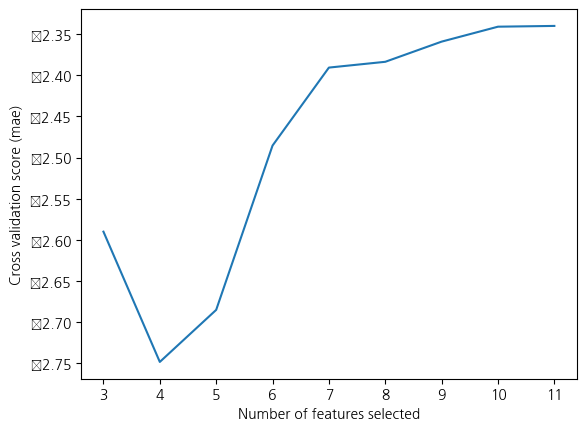

In [55]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [56]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율',
       '일사합'],
      dtype='object')

최고기온 예측

In [60]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최저기온']]
train_y = train["최고기온"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 2
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c7570cf7610>,
      min_features_to_select=2,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

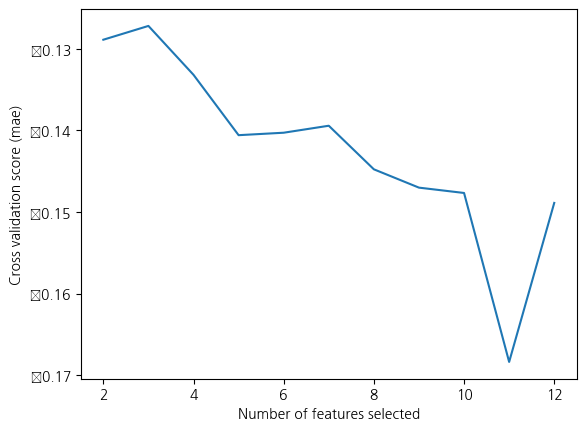

In [61]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [62]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['일교차', '일사합', '최저기온'], dtype='object')

평균습도 예측

In [57]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최저기온', '최고기온']]
train_y = train["평균습도"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c759de54dc0>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

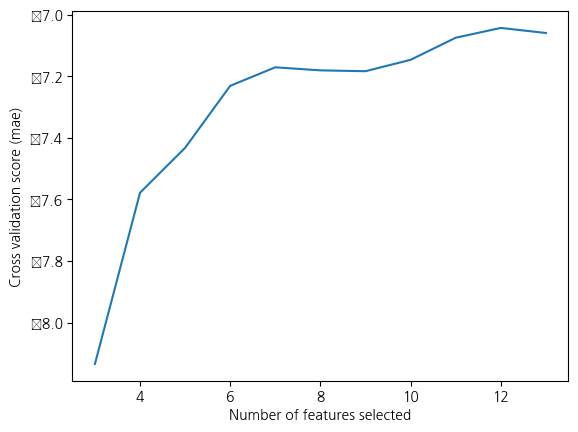

In [58]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [59]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['년', '월', 'Day sin', 'Day cos', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합',
       '최저기온', '최고기온'],
      dtype='object')

강수량 예측

In [63]:
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

train_x = train[['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최저기온', '최고기온', '평균습도']]
train_y = train["강수량"]

# RandomForestClassifier 모델 생성
cat = CatBoostRegressor(boosting_type='Ordered', verbose=False)

step = 1
min_features_to_select = 3
selector = RFECV(cat, step=step, cv=5, min_features_to_select=min_features_to_select, scoring=mae_scorer)

# 모델 학습
selector.fit(train_x, train_y)

RFECV(cv=5,
      estimator=<catboost.core.CatBoostRegressor object at 0x7c7570cf7940>,
      min_features_to_select=3,
      scoring=make_scorer(mean_absolute_error, greater_is_better=False))

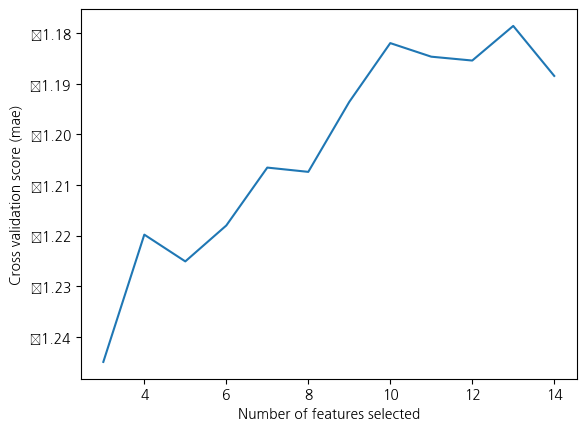

In [64]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (mae)")
plt.plot(
    range(min_features_to_select, len(selector.cv_results_['mean_test_score']) * step + min_features_to_select, step),
    selector.cv_results_['mean_test_score'],
)
plt.show()

In [65]:
# RFECV로 선택된 feature
train_x.columns[selector.support_]

Index(['년', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합',
       '최저기온', '최고기온', '평균습도'],
      dtype='object')

### 모델링

In [35]:
submit

,일시,평균기온,년,월,일,Day sin,Day cos,주
0,2023-01-01,0,2023,1,1,1.754990e-02,0.999846,52
1,2023-01-02,0,2023,1,2,3.509439e-02,0.999384,1
2,2023-01-03,0,2023,1,3,5.262807e-02,0.998614,1
3,2023-01-04,0,2023,1,4,7.014554e-02,0.997537,1
4,2023-01-05,0,2023,1,5,8.764140e-02,0.996152,1
...,...,...,...,...,...,...,...,...
353,2023-12-20,0,2023,12,20,-7.014554e-02,0.997537,51
354,2023-12-21,0,2023,12,21,-5.262807e-02,0.998614,51
355,2023-12-22,0,2023,12,22,-3.509439e-02,0.999384,51
356,2023-12-23,0,2023,12,23,-1.754990e-02,0.999846,51


평균풍속 예측

In [36]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', '월', 'Day sin', 'Day cos', '주']
target_variable = '평균풍속'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['평균풍속'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 0.9408610	total: 50.1ms	remaining: 50.1s
1:	learn: 0.9349680	total: 53ms	remaining: 26.5s
2:	learn: 0.9308491	total: 56ms	remaining: 18.6s
3:	learn: 0.9262928	total: 58.3ms	remaining: 14.5s
4:	learn: 0.9223551	total: 60.7ms	remaining: 12.1s
5:	learn: 0.9189586	total: 63.6ms	remaining: 10.5s
6:	learn: 0.9159101	total: 66ms	remaining: 9.36s
7:	learn: 0.9130281	total: 68.2ms	remaining: 8.46s
8:	learn: 0.9103536	total: 70.8ms	remaining: 7.79s
9:	learn: 0.9081508	total: 73.2ms	remaining: 7.24s
10:	learn: 0.9064684	total: 75.8ms	remaining: 6.81s
11:	learn: 0.9043834	total: 78.2ms	remaining: 6.44s
12:	learn: 0.9027357	total: 80.5ms	remaining: 6.11s
13:	learn: 0.9014065	total: 82.8ms	remaining: 5.83s
14:	learn: 0.9001312	total: 85.2ms	remaining: 5.59s
15:	learn: 0.8985546	total: 87.4ms	remaining: 5.38s
16:	learn: 0.8974557	total: 89.9ms	remaining: 5.2s
17:	learn: 0.8962084	total: 92.5ms	remaining: 5.04s
18:	learn: 0.8949936	total: 94.8ms	remaining: 4.89s

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309


일교차 예측

In [37]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['Day sin', 'Day cos', '평균풍속']
target_variable = '일교차'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
ccat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['일교차'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 2.8734669	total: 2.6ms	remaining: 2.6s
1:	learn: 2.8434656	total: 5.42ms	remaining: 2.7s
2:	learn: 2.8152904	total: 8.12ms	remaining: 2.7s
3:	learn: 2.7907216	total: 10.8ms	remaining: 2.68s
4:	learn: 2.7677189	total: 13.4ms	remaining: 2.67s
5:	learn: 2.7474304	total: 16.1ms	remaining: 2.66s
6:	learn: 2.7297085	total: 18.8ms	remaining: 2.66s
7:	learn: 2.7138691	total: 21.2ms	remaining: 2.63s
8:	learn: 2.6993894	total: 23.8ms	remaining: 2.62s
9:	learn: 2.6860043	total: 26ms	remaining: 2.57s
10:	learn: 2.6740870	total: 28.4ms	remaining: 2.56s
11:	learn: 2.6635106	total: 30.8ms	remaining: 2.53s
12:	learn: 2.6528463	total: 32.9ms	remaining: 2.5s
13:	learn: 2.6441812	total: 35.3ms	remaining: 2.49s
14:	learn: 2.6367325	total: 37.8ms	remaining: 2.48s
15:	learn: 2.6296040	total: 40.2ms	remaining: 2.47s
16:	learn: 2.6238160	total: 42.4ms	remaining: 2.45s
17:	learn: 2.6180084	total: 44.7ms	remaining: 2.44s
18:	learn: 2.6129149	total: 46.9ms	remaining: 2.42s

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938


일조합 예측

In [38]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', 'Day sin', 'Day cos', '주', '평균풍속', '일교차']
target_variable = '일조합'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['일조합'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 3.7025835	total: 3.1ms	remaining: 3.09s
1:	learn: 3.5848657	total: 6.3ms	remaining: 3.14s
2:	learn: 3.4781861	total: 9.35ms	remaining: 3.11s
3:	learn: 3.3836082	total: 12.2ms	remaining: 3.03s
4:	learn: 3.2940687	total: 14.7ms	remaining: 2.93s
5:	learn: 3.2131175	total: 17.3ms	remaining: 2.87s
6:	learn: 3.1397007	total: 20.7ms	remaining: 2.93s
7:	learn: 3.0758576	total: 24ms	remaining: 2.98s
8:	learn: 3.0188899	total: 27.1ms	remaining: 2.98s
9:	learn: 2.9659140	total: 29.6ms	remaining: 2.93s
10:	learn: 2.9161299	total: 32.5ms	remaining: 2.92s
11:	learn: 2.8733886	total: 34.9ms	remaining: 2.87s
12:	learn: 2.8334069	total: 37.3ms	remaining: 2.83s
13:	learn: 2.7993229	total: 39.8ms	remaining: 2.8s
14:	learn: 2.7671889	total: 42.5ms	remaining: 2.79s
15:	learn: 2.7366888	total: 45.5ms	remaining: 2.8s
16:	learn: 2.7102598	total: 49ms	remaining: 2.83s
17:	learn: 2.6861813	total: 51.7ms	remaining: 2.82s
18:	learn: 2.6643855	total: 54.1ms	remaining: 2.79s


,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292


일조율 예측

In [39]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['Day cos', '주', '일조합']
target_variable = '일조율'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['일조율'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 29.6241847	total: 2.69ms	remaining: 2.69s
1:	learn: 27.7320415	total: 6.64ms	remaining: 3.31s
2:	learn: 25.9528887	total: 8.98ms	remaining: 2.98s
3:	learn: 24.2962644	total: 11.4ms	remaining: 2.85s
4:	learn: 22.7648432	total: 13.8ms	remaining: 2.74s
5:	learn: 21.3352270	total: 17.8ms	remaining: 2.94s
6:	learn: 20.0061152	total: 19.9ms	remaining: 2.83s
7:	learn: 18.7458506	total: 22.2ms	remaining: 2.75s
8:	learn: 17.5776435	total: 24.8ms	remaining: 2.73s
9:	learn: 16.4714128	total: 27.2ms	remaining: 2.69s
10:	learn: 15.4516814	total: 29.7ms	remaining: 2.67s
11:	learn: 14.4952981	total: 32.2ms	remaining: 2.65s
12:	learn: 13.6144437	total: 36.5ms	remaining: 2.77s
13:	learn: 12.7960016	total: 41.6ms	remaining: 2.93s
14:	learn: 12.0262482	total: 44.7ms	remaining: 2.94s
15:	learn: 11.3099138	total: 47.5ms	remaining: 2.92s
16:	learn: 10.6297502	total: 49.9ms	remaining: 2.89s
17:	learn: 9.9904244	total: 52.4ms	remaining: 2.86s
18:	learn: 9.3923200	total:

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합,일조율
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684,57.922415
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292,60.425240


일사합 예측

In [40]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율']
target_variable = '일사합'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['일사합'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 5.8285852	total: 7.18ms	remaining: 7.17s
1:	learn: 5.5287626	total: 10.5ms	remaining: 5.25s
2:	learn: 5.2449275	total: 13.9ms	remaining: 4.61s
3:	learn: 4.9829266	total: 16.8ms	remaining: 4.18s
4:	learn: 4.7379309	total: 19.4ms	remaining: 3.87s
5:	learn: 4.5116126	total: 22.5ms	remaining: 3.72s
6:	learn: 4.2991144	total: 25.6ms	remaining: 3.63s
7:	learn: 4.1030560	total: 28.4ms	remaining: 3.52s
8:	learn: 3.9181347	total: 31.8ms	remaining: 3.5s
9:	learn: 3.7476303	total: 35.6ms	remaining: 3.53s
10:	learn: 3.5914765	total: 39.1ms	remaining: 3.52s
11:	learn: 3.4494345	total: 42.4ms	remaining: 3.49s
12:	learn: 3.3124752	total: 46ms	remaining: 3.49s
13:	learn: 3.1942077	total: 48.9ms	remaining: 3.44s
14:	learn: 3.0830745	total: 51.8ms	remaining: 3.4s
15:	learn: 2.9867876	total: 54.6ms	remaining: 3.36s
16:	learn: 2.8908272	total: 57.6ms	remaining: 3.33s
17:	learn: 2.7989278	total: 60.2ms	remaining: 3.29s
18:	learn: 2.7142891	total: 63.3ms	remaining: 3.

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합,일조율,일사합
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684,57.922415,8.291516
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292,60.425240,8.548222


최저기온 예측

In [41]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', '월', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합']
target_variable = '최저기온'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['최저기온'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 9.9723021	total: 3.1ms	remaining: 3.1s
1:	learn: 9.4131614	total: 6.05ms	remaining: 3.02s
2:	learn: 8.8768742	total: 9.12ms	remaining: 3.03s
3:	learn: 8.3772455	total: 12ms	remaining: 2.99s
4:	learn: 7.9304467	total: 14.8ms	remaining: 2.94s
5:	learn: 7.5130990	total: 18.9ms	remaining: 3.13s
6:	learn: 7.1184323	total: 22ms	remaining: 3.12s
7:	learn: 6.7611130	total: 25.8ms	remaining: 3.19s
8:	learn: 6.4153927	total: 28.6ms	remaining: 3.15s
9:	learn: 6.1049361	total: 31.4ms	remaining: 3.1s
10:	learn: 5.8177961	total: 37.1ms	remaining: 3.33s
11:	learn: 5.5517879	total: 40.5ms	remaining: 3.33s
12:	learn: 5.3075281	total: 43.5ms	remaining: 3.3s
13:	learn: 5.0780647	total: 46.8ms	remaining: 3.29s
14:	learn: 4.8716595	total: 49.8ms	remaining: 3.27s
15:	learn: 4.6821135	total: 52.9ms	remaining: 3.25s
16:	learn: 4.5151499	total: 57.6ms	remaining: 3.33s
17:	learn: 4.3622743	total: 62.4ms	remaining: 3.41s
18:	learn: 4.2238739	total: 65.3ms	remaining: 3.37s


,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합,일조율,일사합,최저기온
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684,57.922415,8.291516,-5.602652
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292,60.425240,8.548222,-5.925554


최고기온 예측

In [73]:
submit['최고기온'] = submit['최저기온'] + submit['일교차']
submit.head(2)

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합,일조율,일사합,최저기온,최고기온
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684,57.922415,8.291516,-5.602652,2.112708
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292,60.425240,8.548222,-5.925554,1.358383


평균습도 예측

In [45]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', '월', 'Day sin', 'Day cos', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최저기온', '최고기온']
target_variable = '평균습도'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['평균습도'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 14.0421817	total: 3.58ms	remaining: 3.58s
1:	learn: 13.5825715	total: 6.49ms	remaining: 3.24s
2:	learn: 13.1609540	total: 9.41ms	remaining: 3.13s
3:	learn: 12.7839281	total: 12.5ms	remaining: 3.12s
4:	learn: 12.4472046	total: 16.1ms	remaining: 3.2s
5:	learn: 12.1307084	total: 18.9ms	remaining: 3.12s
6:	learn: 11.8358471	total: 21.9ms	remaining: 3.1s
7:	learn: 11.5796436	total: 25ms	remaining: 3.1s
8:	learn: 11.3380250	total: 28ms	remaining: 3.08s
9:	learn: 11.1264878	total: 30.9ms	remaining: 3.06s
10:	learn: 10.9244113	total: 34ms	remaining: 3.05s
11:	learn: 10.7450074	total: 37.2ms	remaining: 3.06s
12:	learn: 10.5769550	total: 40.6ms	remaining: 3.08s
13:	learn: 10.4338319	total: 43.6ms	remaining: 3.07s
14:	learn: 10.3027689	total: 46.9ms	remaining: 3.08s
15:	learn: 10.1826805	total: 50.2ms	remaining: 3.09s
16:	learn: 10.0804447	total: 53.3ms	remaining: 3.08s
17:	learn: 9.9862952	total: 56.5ms	remaining: 3.08s
18:	learn: 9.8857299	total: 59.8ms	r

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합,일조율,일사합,최저기온,최고기온,평균습도
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684,57.922415,8.291516,-5.602652,2.049102,59.081200
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292,60.425240,8.548222,-5.925554,1.590875,57.513091


강수량 예측

In [46]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', 'Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최저기온', '최고기온', '평균습도']
target_variable = '강수량'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

submit['강수량'] = submission_pred
submit.head(2)

Learning rate set to 0.067199
0:	learn: 1.4575393	total: 3.67ms	remaining: 3.67s
1:	learn: 1.4443673	total: 6.9ms	remaining: 3.44s
2:	learn: 1.4331427	total: 9.63ms	remaining: 3.2s
3:	learn: 1.4220088	total: 12.5ms	remaining: 3.11s
4:	learn: 1.4125489	total: 15.4ms	remaining: 3.06s
5:	learn: 1.4040025	total: 18.4ms	remaining: 3.05s
6:	learn: 1.3969256	total: 21ms	remaining: 2.98s
7:	learn: 1.3906255	total: 23.8ms	remaining: 2.95s
8:	learn: 1.3848081	total: 26.6ms	remaining: 2.93s
9:	learn: 1.3796283	total: 29.5ms	remaining: 2.92s
10:	learn: 1.3747618	total: 32.3ms	remaining: 2.91s
11:	learn: 1.3704720	total: 35.3ms	remaining: 2.9s
12:	learn: 1.3667725	total: 38.4ms	remaining: 2.91s
13:	learn: 1.3629856	total: 41.2ms	remaining: 2.9s
14:	learn: 1.3594355	total: 44ms	remaining: 2.89s
15:	learn: 1.3564130	total: 47ms	remaining: 2.89s
16:	learn: 1.3540612	total: 50.1ms	remaining: 2.9s
17:	learn: 1.3521557	total: 52.8ms	remaining: 2.88s
18:	learn: 1.3503218	total: 55.6ms	remaining: 2.87s
19:

,일시,평균기온,년,월,일,Day sin,Day cos,주,평균풍속,일교차,일조합,일조율,일사합,최저기온,최고기온,평균습도,강수량
0,2023-01-01,0,2023,1,1,0.017550,0.999846,52,1.791299,7.715361,5.61684,57.922415,8.291516,-5.602652,2.049102,59.081200,0.625308
1,2023-01-02,0,2023,1,2,0.035094,0.999384,1,2.021309,7.283938,5.82292,60.425240,8.548222,-5.925554,1.590875,57.513091,0.540023


평균 기온 예측
- ['년', '월', '평균풍속', '일조합', '최고기온', '최저기온'], 타겟 : 평균기온, MAE: 0.371 -> 0.362

In [47]:
# 필요한 변수 선택 (예시로 선택된 변수들이므로 실제로 사용하는 변수에 맞게 수정 필요)
selected_features = ['년', '월','Day sin', 'Day cos', '일', '주', '평균풍속', '일교차', '일조합', '일조율', '일사합', '최저기온', '최고기온', '평균습도', '강수량']
target_variable = '평균기온'

# 선택된 변수들을 사용하여 훈련 데이터셋 준비
train_x = train[selected_features]
train_y = train[target_variable]

test_x = submit[selected_features]

# 모델 정의
cat = CatBoostRegressor(random_state = 42)

# 모델 학습
cat.fit(train_x, train_y)

# 예측 수행
submission_pred = cat.predict(test_x)

Learning rate set to 0.067199
0:	learn: 9.8373928	total: 3.06ms	remaining: 3.06s
1:	learn: 9.2168146	total: 6.15ms	remaining: 3.07s
2:	learn: 8.6392911	total: 9.26ms	remaining: 3.08s
3:	learn: 8.0973891	total: 12.5ms	remaining: 3.12s
4:	learn: 7.5873828	total: 15.6ms	remaining: 3.1s
5:	learn: 7.1141153	total: 18.8ms	remaining: 3.11s
6:	learn: 6.6742760	total: 21.6ms	remaining: 3.07s
7:	learn: 6.2561296	total: 24.8ms	remaining: 3.07s
8:	learn: 5.8683367	total: 27.9ms	remaining: 3.07s
9:	learn: 5.5085333	total: 30.9ms	remaining: 3.06s
10:	learn: 5.1784341	total: 34.1ms	remaining: 3.07s
11:	learn: 4.8609281	total: 37.5ms	remaining: 3.08s
12:	learn: 4.5678013	total: 40.9ms	remaining: 3.1s
13:	learn: 4.2885958	total: 44.2ms	remaining: 3.12s
14:	learn: 4.0364590	total: 47.5ms	remaining: 3.12s
15:	learn: 3.7883856	total: 50.8ms	remaining: 3.13s
16:	learn: 3.5590079	total: 53.7ms	remaining: 3.1s
17:	learn: 3.3565200	total: 56.6ms	remaining: 3.09s
18:	learn: 3.1549131	total: 60ms	remaining: 3.1

In [48]:
submission = pd.read_csv('sample_submission.csv')
submission['평균기온']=submission_pred

In [49]:
# 예측값 확인
submission

,일시,평균기온
0,2023-01-01,-1.846188
1,2023-01-02,-2.308622
2,2023-01-03,-2.529953
3,2023-01-04,-2.796823
4,2023-01-05,-2.866608
...,...,...
353,2023-12-20,-4.061805
354,2023-12-21,-3.390984
355,2023-12-22,-4.231861
356,2023-12-23,-4.008548


In [50]:
submission.to_csv('catboost.csv', index=False)